<a href="https://colab.research.google.com/github/PrajwalRaj21/Major-Project/blob/main/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Installing Necessary Libraries**

In [ ]:
!pip install tensorflow opencv-python


# **Preparing the dataset**
# Step 1: Loading and Preprocessing Data

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Parameters
num_frames = 10
height, width = 64, 64  # Ensure these match your input size
channels = 1  # Grayscale images

# Data path and categories
data_path = '/content/drive/MyDrive/Project Dataset/data'
categories = ['word_1', 'word_2', 'word_3', 'word_4']
labels = {category: i for i, category in enumerate(categories)}

def load_data():
    images = []
    targets = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (width, height))  # Resize to desired input size
            images.append(img)
            targets.append(labels[category])
    images = np.array(images)
    targets = np.array(targets)
    images = images.reshape(images.shape[0], height, width, channels) / 255.0  # Normalize
    targets = to_categorical(targets, num_classes=len(categories))
    return train_test_split(images, targets, test_size=0.2, random_state=42)

def create_sequences(images, labels, num_frames):
    sequences = []
    sequence_labels = []

    for i in range(0, len(images) - num_frames + 1, num_frames):
        seq_images = images[i:i+num_frames]
        seq_labels = labels[i:i+num_frames]

        # Ensure all sequences have the same length
        if len(seq_images) == num_frames:
            sequences.append(seq_images)
            sequence_labels.append(seq_labels[-1])  # Label of the last frame in the sequence

    return np.array(sequences), np.array(sequence_labels)

# Load and preprocess data
X_train, X_test, y_train, y_test = load_data()

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, num_frames)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, num_frames)

# Print shapes for verification
print("Training Sequences Shape:", X_train_seq.shape)
print("Training Labels Shape:", y_train_seq.shape)
print("Testing Sequences Shape:", X_test_seq.shape)
print("Testing Labels Shape:", y_test_seq.shape)


Training Sequences Shape: (96, 10, 64, 64, 1)
Training Labels Shape: (96, 4)
Testing Sequences Shape: (24, 10, 64, 64, 1)
Testing Labels Shape: (24, 4)


# Step 2: Defining the CNN+LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed

def build_model():
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(num_frames, height, width, channels)),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()


# Step 3: Training the Model

In [ ]:
history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))


Epoch 1/10
3/3 [==============================] - 12s 3s/step - loss: 1.6779 - accuracy: 0.2396 - val_loss: 1.3333 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 8s 2s/step - loss: 1.4373 - accuracy: 0.2917 - val_loss: 1.2378 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 8s 3s/step - loss: 1.3460 - accuracy: 0.3333 - val_loss: 1.2503 - val_accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 8s 2s/step - loss: 1.2341 - accuracy: 0.3958 - val_loss: 1.0764 - val_accuracy: 0.9167
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 1.0714 - accuracy: 0.5833 - val_loss: 0.9671 - val_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 1.0399 - accuracy: 0.6042 - val_loss: 0.8913 - val_accuracy: 0.8333
Epoch 7/10
3/3 [==============================] - 10s 4s/step - loss: 0.8480 - accuracy: 0.8125 - val_loss: 0.7977 - val_accuracy: 0.9167
Epoch 8/10
3/3 [=======================

*Downloading the Model*

In [ ]:
model.save('/content/drive/MyDrive/nepali_slr_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Plotting The Confusion Matrix**

1/1 [==============================] - 2s 2s/step


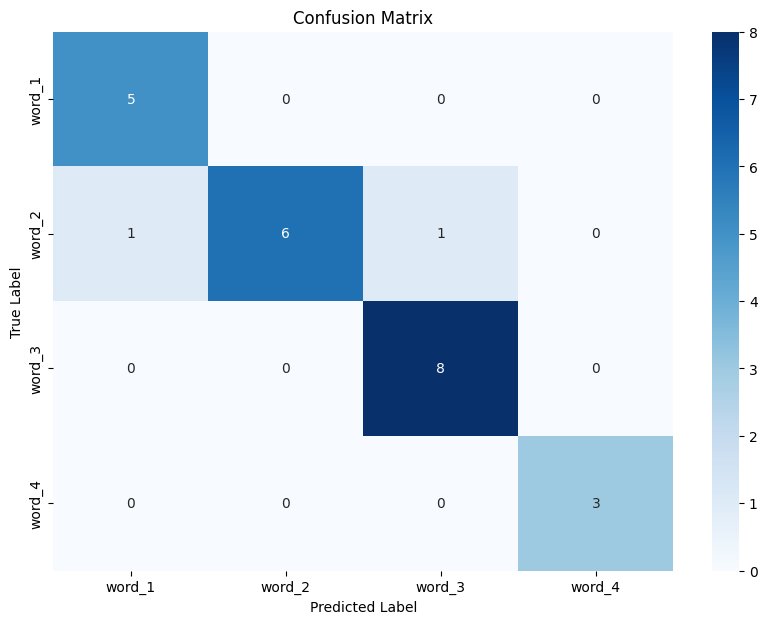

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred_prob = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_prob, axis=1)


y_true = np.argmax(y_test_seq, axis=1)


cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
